## Predicting ICD Codes - A Multi-Class Classfication Problem

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc

### The Data
Below, the data is loaded and the text (lines from diagnostics reports) is tokenized for use by various modeling techinques hereafter.

In [28]:
import nltk

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def tokenizer(row):
    '''
    This function takes in a string of text and
    returns a string of all unique tokens after removing
    stop words, stemming and lemmatizing the words
    and converting all words to lower case.

    Arguments
    ---------
    text: str
        string of text to be tokenized

    Returns
    -------
    str
       string of unique words lower cased, stemmed and lemmatized 
       with no stop words from the text input
    '''
    swords = stopwords.words('english')
    
    tokens = set(nltk.word_tokenize(row['text']))    
    
    tokens_without_stop_words = [token for token in tokens if not token in swords]    
    
    stemmer = PorterStemmer()
    stems = set([stemmer.stem(token) for token in tokens_without_stop_words])    
    
    lemma = WordNetLemmatizer()
    lemmas = set([lemma.lemmatize(token) for token in stems])  
    
    words = [token.lower() for token in lemmas]    
    
    return ' '.join(words)

In [29]:
df_lines = pd.read_csv('Data/discharge_note_lines.csv', sep='|')

df_lines = df_lines.loc[df_lines['valid'] == True]

df_lines['tokens'] = df_lines.apply(tokenizer, axis=1)

df_lines.head()

,line_id,text,icd_code,valid,tokens
452,8685,Diabetic ketoacidosis Influenza A Type 1 Diabe...,E1010,True,a metabol 1 syndrom ketoacidosi diabet influen...
453,20896,"___ - C4-C5 Corpectomy, C3-C6 Fusion by Dr. __...",E232,True,"- corpectomi diabet 23:45 , insipidu die fusio..."
994,11203,None DIABETIC KETOACIDOSIS TYPE 1 DIABETES MEL...,E1010,True,1 pneumomediastinum ketoacidosi diabet type me...
1011,16174,T1DM Panic Disorder No FH of diabetes. Diabeti...,E1010,True,. disord no 1 panic ketoacidosi diabet type t1...
1775,6316,#BRPBPR #Shoulder Pain #Hip Pain #Hep C Cirrho...,E1165,True,2 brpbpr diabet hip c type pain hyperglycemia ...


### Test / Train Split

In [30]:
X = df_lines.drop('icd_code', axis = 1)
y = df_lines['icd_code']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X['tokens'], y, random_state = 42)

In [32]:
print('Training dataset count: ' + str(len(X_train.index)))
print('Test dataset count: ' + str(len(X_test.index)))

Training dataset count: 113
Test dataset count: 38


### Logistic Regression

#### Text Vectorization using Count Vectorizer
Use of vectorization tool CountVectorizer to create a bag of words representation of text in a DataFrame.
Using Pipeline with named steps to vectorize and model the data, and using grid search for the ideal parameters to represent the text and build a classification model.
Logistics Regression techniques being evaluated:
- One vs. Rest classification, 
- Multinomial classification, and 
- One vs one classifier techniques

In [33]:
params = {
    'cvect__max_features': [100, 200, 500, 1000, 2000],
    'cvect__stop_words': ['english', None]
}

In [34]:
bow_pipe1 = Pipeline([
    ('cvect', CountVectorizer()), 
    ('lgr', LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42))    
])

bow_grid1 = GridSearchCV(bow_pipe1, param_grid=params).fit(X_train, y_train)

bow_pipe2 = Pipeline([
    ('cvect', CountVectorizer()), 
    ('lgr', LogisticRegression(multi_class='multinomial', max_iter=10000, random_state=42))    
])

bow_grid2 = GridSearchCV(bow_pipe2, param_grid=params).fit(X_train, y_train)

bow_pipe3 = Pipeline([
    ('cvect', CountVectorizer()), 
    ('lgr', OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state = 42)))    
])

bow_grid3 = GridSearchCV(bow_pipe3, param_grid=params).fit(X_train, y_train)

##### Evaluation: 
Compare the scores on testing data in terms of accuracy.

In [35]:
df_bow_comp = pd.DataFrame(
    {
        'estimator': ['ovr', 'multi', 'ovo'], 
        'accuracy': [bow_grid1.score(X_test, y_test), bow_grid2.score(X_test, y_test), bow_grid3.score(X_test, y_test)],
        'best params': [bow_grid1.best_params_, bow_grid2.best_params_, bow_grid3.best_params_]
    }
)

df_bow_comp.head()

,estimator,accuracy,best params
0,ovr,0.710526,"{'cvect__max_features': 100, 'cvect__stop_word..."
1,multi,0.763158,"{'cvect__max_features': 100, 'cvect__stop_word..."
2,ovo,0.684211,"{'cvect__max_features': 200, 'cvect__stop_word..."


In [73]:
best_bow_acc = df_bow_comp.loc[df_bow_comp['accuracy'].idxmax()]['estimator']

print('Best Performance: ' + best_bow_acc)

Best Performance: multi


###### Confusion Matrices

In [75]:
def build_confusion_matrix(preds, title):
    '''
    This function takes in predictions and draws 
    the confusion matrix against test data.

    Arguments
    ---------
    preds: Series
        Predictions against the test data
    title: string
        Title of the plot
    '''   
    plt.figure(figsize = (6,3))
    conf_matrix = confusion_matrix(y_test, preds)
    sns.heatmap(conf_matrix, annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    
    # ROC Curve
    #fpr, tpr, thresholds = roc_curve(y_test, pd.Series(y_score), pos_label='Yes')
    #roc_auc_value = auc(fpr, tpr)

    #disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    #disp2.plot()
    return;

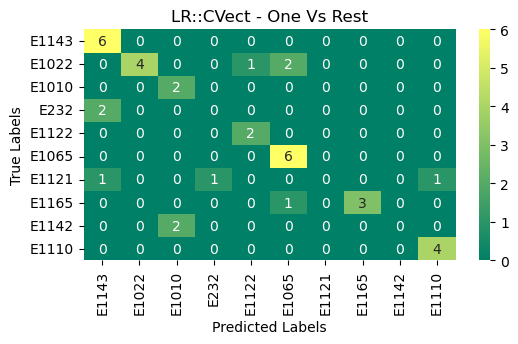

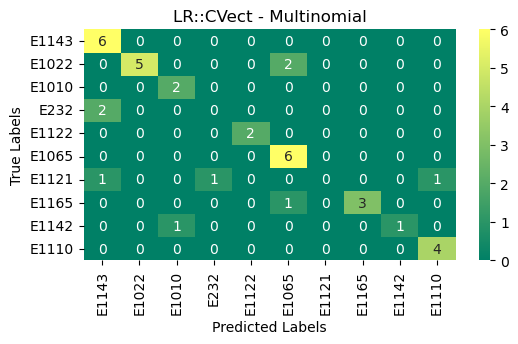

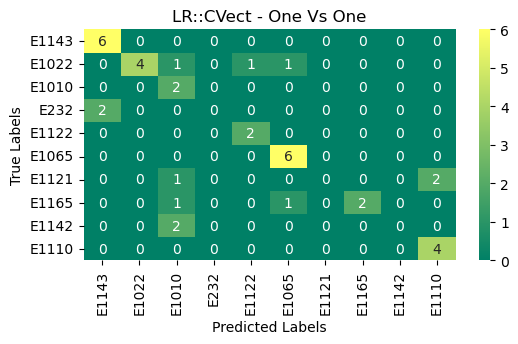

In [88]:
build_confusion_matrix(bow_grid1.predict(X_test), 'LR::CVect - One Vs Rest') # bow_grid1.predict_proba(X_test)[:, 1], 'test'
build_confusion_matrix(bow_grid2.predict(X_test), 'LR::CVect - Multinomial') # bow_grid2.predict_proba(X_test)[:, 1], 'test'
build_confusion_matrix(bow_grid3.predict(X_test), 'LR::CVect - One Vs One') # bow_grid3.predict_proba(X_test)[:, 1], 'test'

#### Text Vectorization using TFIDF
Use of vectorization tool TfidfVectorizer.
Using Pipeline with named steps to vectorize and model the data, and using grid search for the ideal parameters to represent the text and build a classification model.
Logistics Regression techniques being evaluated:
- One vs. Rest classification, 
- Multinomial classification, and 
- One vs one classifier techniques

In [78]:
params = {
    'tfidf__max_features': [100, 200, 500, 1000, 2000],
    'tfidf__stop_words': ['english', None]
}

In [79]:
tfidf_pipe1 = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('lgr', LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42))
])

tfidf_grid1 = GridSearchCV(tfidf_pipe1, param_grid=params).fit(X_train, y_train)

tfidf_pipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('lgr', LogisticRegression(multi_class='multinomial', max_iter=10000, random_state=42))
])

tfidf_grid2 = GridSearchCV(tfidf_pipe2, param_grid=params).fit(X_train, y_train)

tfidf_pipe3 = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('lgr', OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state = 42)))
])

tfidf_grid3 = GridSearchCV(tfidf_pipe3, param_grid=params).fit(X_train, y_train)


##### Evaluation: 
Compare the scores on testing data in terms of accuracy.

In [80]:
df_tfidf_comp = pd.DataFrame(
    {
        'estimator': ['ovr', 'multi', 'ovo'], 
        'accuracy': [tfidf_grid1.score(X_test, y_test), tfidf_grid2.score(X_test, y_test), tfidf_grid3.score(X_test, y_test)],
        'best params': [tfidf_grid1.best_params_, tfidf_grid2.best_params_, tfidf_grid3.best_params_]
    }
)

df_tfidf_comp.head()

,estimator,accuracy,best params
0,ovr,0.631579,"{'tfidf__max_features': 100, 'tfidf__stop_word..."
1,multi,0.631579,"{'tfidf__max_features': 100, 'tfidf__stop_word..."
2,ovo,0.552632,"{'tfidf__max_features': 100, 'tfidf__stop_word..."


In [81]:
df_tfidf_comp = df_tfidf_comp.loc[df_tfidf_comp['accuracy'].idxmax()]['estimator']

print('Best Performance: ' + df_tfidf_comp)

Best Performance: ovr


###### Confusion Matrices

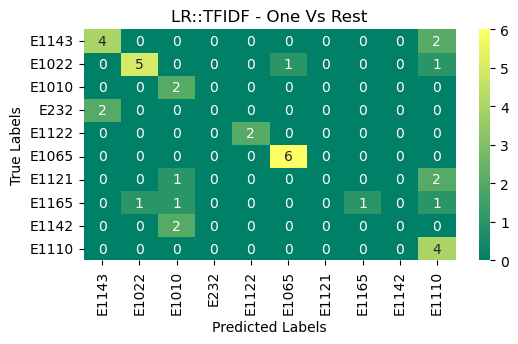

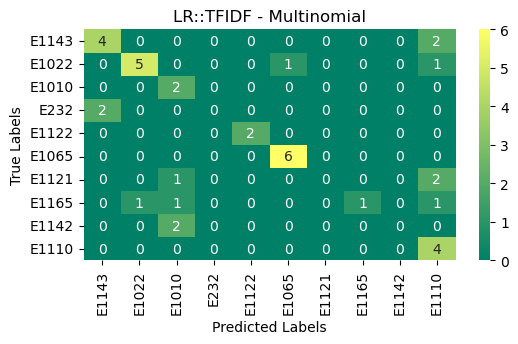

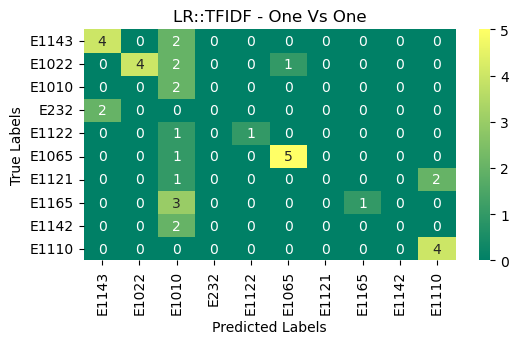

In [89]:
build_confusion_matrix(tfidf_grid1.predict(X_test), 'LR::TFIDF - One Vs Rest')
build_confusion_matrix(tfidf_grid2.predict(X_test), 'LR::TFIDF - Multinomial')
build_confusion_matrix(tfidf_grid3.predict(X_test), 'LR::TFIDF - One Vs One')

### Naive Bayes
Text vectorization strategies
- Count Vectorization
- TFIDF

#### Text Vectorization using TFIDF

In [83]:
params = {
    'cvect__max_features': [100, 200, 500, 1000, 2000],
    'cvect__stop_words': ['english', None]
}

nb_cvect_pipe = Pipeline([
    ('cvect', CountVectorizer()),
    ('bayes', MultinomialNB())
])

nb_cvect_grid = GridSearchCV(nb_cvect_pipe, param_grid=params).fit(X_train, y_train)

#### Text Vectorization using Count Vectorization

In [84]:
params = {
    'tfidf__max_features': [100, 200, 500, 1000, 2000],
    'tfidf__stop_words': ['english', None]
}

nb_tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bayes', MultinomialNB())
])

nb_tfidf_grid = GridSearchCV(nb_tfidf_pipe, param_grid=params).fit(X_train, y_train)

##### Evaluation: 
Compare the scores on testing data in terms of accuracy.

In [85]:
df_nb_comp = pd.DataFrame(
    {
        'estimator': ['cvect', 'tfidf'], 
        'accuracy': [nb_cvect_grid.score(X_test, y_test), nb_tfidf_grid.score(X_test, y_test)],
        'best params': [nb_cvect_grid.best_params_, nb_tfidf_grid.best_params_]
    }
)

df_nb_comp.head()

,estimator,accuracy,best params
0,cvect,0.605263,"{'cvect__max_features': 100, 'cvect__stop_word..."
1,tfidf,0.552632,"{'tfidf__max_features': 100, 'tfidf__stop_word..."


In [86]:
df_nb_comp = df_nb_comp.loc[df_nb_comp['accuracy'].idxmax()]['estimator']

print('Best Performance: ' + df_nb_comp)

Best Performance: cvect


###### Confusion Matrices

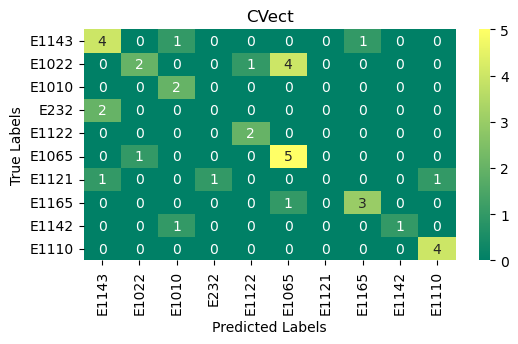

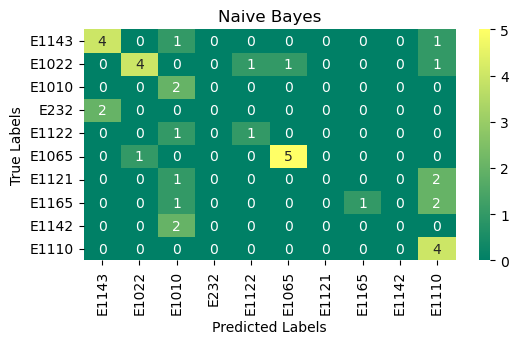

In [87]:
build_confusion_matrix(nb_cvect_grid.predict(X_test), 'CVect')
build_confusion_matrix(nb_tfidf_grid.predict(X_test), 'Naive Bayes')